Laboratorio 2
=============

Calibración de modelos tomando ventanas históricas 
===

In [1]:
library(ggplot2)

In [2]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [12]:
library(lubridate)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Usamos la función "read.csv" para leer un archivo CSV y almacenar el contenido en un dataframe.

El archivo es leido desde un repositorio en la nube (Cloud repository) de acceso libre (Zenodo.org).

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11111086.svg)](https://doi.org/10.5281/zenodo.11111086)

In [4]:
data_cmg <- read.csv("https://zenodo.org/record/11111086/files/CMg_daily_weighted_average_2005_20223_sharing.csv", header = TRUE)

In [5]:
head(data_cmg) # muestra la cabecera y primeros registros del dataframe

,Time,Name_day,Price
,<fct>,<fct>,<dbl>
1,2005-01-01 00:00:00,Saturday,0.002801296
2,2005-01-02 00:00:00,Sunday,0.011459184
3,2005-01-03 00:00:00,Monday,0.048284044
4,2005-01-04 00:00:00,Tuesday,0.056741816
5,2005-01-05 00:00:00,Wednesday,0.060451817
6,2005-01-06 00:00:00,Thursday,0.048211718


In [6]:
str(data_cmg) # Muestra la estructura de los datos

'data.frame':	6939 obs. of  3 variables:
 $ Time    : Factor w/ 6939 levels "2005-01-01 00:00:00",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Name_day: Factor w/ 7 levels "Friday","Monday",..: 3 4 2 6 7 5 1 3 4 2 ...
 $ Price   : num  0.0028 0.0115 0.0483 0.0567 0.0605 ...


Notemos que el campo (la columna) "Time" ha sido leído como del tipo "character" (chr).
Para la correcta manipulación del campo tiempo, modificaremos el tipo de ese campo para que sea trabajado como de tipo "date" (fecha y hora).

In [7]:
data_cmg$Time <- as.Date(data_cmg$Time) # la función as.Date(value) retorna el valor "value" modificando el tipo a "date"

Modificamos también el campo (la columna) "Price" que venía expresado en "Soles/kWh", multiplicando por 1000 para que quede expresado en "Soles/MWh" de modo de tener una dimensión más habitual del precio spot. 

In [8]:
data_cmg$Price <- data_cmg$Price * 1000

In [9]:
head(data_cmg) # muestra la cabecera y primeros registros del dataframe

,Time,Name_day,Price
,<date>,<fct>,<dbl>
1,2005-01-01,Saturday,2.801296
2,2005-01-02,Sunday,11.459184
3,2005-01-03,Monday,48.284044
4,2005-01-04,Tuesday,56.741816
5,2005-01-05,Wednesday,60.451817
6,2005-01-06,Thursday,48.211718


In [9]:
str(data_cmg) # muestra la estructura de los datos

'data.frame':	6939 obs. of  3 variables:
 $ Time    : Date, format: "2005-01-01" "2005-01-02" ...
 $ Name_day: chr  "Saturday" "Sunday" "Monday" "Tuesday" ...
 $ Price   : num  2.8 11.5 48.3 56.7 60.5 ...


Etiquetando los precios de estiaje y avenida
===

Vamos a preparar la data para identificar los precios que pertenecen a estiaje y avenida

In [13]:
data_cmg <- data_cmg %>%
  select(Time,
         Name_day,
         Price
  ) %>%
  mutate( # con este comando creamos nuevos campos (columnas) en la tabla
    Month = month(Time),
    Name_month = month(Time, label = TRUE),
    Year = year(Time),
    Estiaje = TRUE # set all as "Estiaje"
  )

Nótese que se creó un campo "Estiaje" establecido como "TRUE" para todos los casos. A continuación modificaremos este campo para "FALSE" en los meses que no son de estiaje, es decir, en los meses que son de avenida.

In [15]:
t_index <- which(data_cmg$Month ==  12)
data_cmg$Estiaje[t_index] = FALSE 

t_index <- which(data_cmg$Month >=  1 & data_cmg$Month <= 5)
data_cmg$Estiaje[t_index] = FALSE

In [16]:
head(data_cmg)

,Time,Name_day,Price,Month,Name_month,Year,Estiaje
,<date>,<fct>,<dbl>,<dbl>,<ord>,<dbl>,<lgl>
1,2005-01-01,Saturday,2.801296,1,Jan,2005,FALSE
2,2005-01-02,Sunday,11.459184,1,Jan,2005,FALSE
3,2005-01-03,Monday,48.284044,1,Jan,2005,FALSE
4,2005-01-04,Tuesday,56.741816,1,Jan,2005,FALSE
5,2005-01-05,Wednesday,60.451817,1,Jan,2005,FALSE
6,2005-01-06,Thursday,48.211718,1,Jan,2005,FALSE


Calibración de la parte determinística de un modelo estocástico
===

Creamos vectores de datos que usaremos para crear un dataframe (una tabla de datos) el cual usaremos en la función "nls" de ajuste no linear por mínimos cuadrados. Usaremos esta función "nls" es la de calibración de parámetros de la parte determínistica del modelo del precio spot. 

In [17]:
Time_dat <- data_cmg$Time 
x_dat <- as.double(data_cmg$Time)
y_dat <- data_cmg$Price
Year_dat <- data_cmg$Year
Estiaje <- data_cmg$Estiaje

Creamos el DataFrame (ds) 

In [18]:
ds <- data.frame(Time = Time_dat, t = x_dat, Price= y_dat, Year = Year_dat, Estiaje = Estiaje)

str(ds)

'data.frame':	6939 obs. of  5 variables:
 $ Time   : Date, format: "2005-01-01" "2005-01-02" ...
 $ t      : num  12784 12785 12786 12787 12788 ...
 $ Price  : num  2.8 11.5 48.3 56.7 60.5 ...
 $ Year   : num  2005 2005 2005 2005 2005 ...
 $ Estiaje: logi  FALSE FALSE FALSE FALSE FALSE FALSE ...


En base al paper de Lucia & Schwartz (2001), sabemos que para la parte determínista del modelo estocástico se puede usar una función sinusoidal del tipo "alpha + gamma*cos((t+Tao)*2*pi/365)". Entonces crearemos una función con esos trés parámetros "alpha", "gamma" y "Tao".

In [19]:
f_determ <- function(t,alpha,gamma,Tao) {
  (alpha + gamma*cos((t+Tao)*2*pi/365))
}

Ahora usaremos la función "nls" para que haga una ajuste de mínimos cuadrados con los datos del dataframe "ds" y para una función determinística como la indicada en la función "f_determ". 

In [20]:
model1 <- nls(Price ~ f_determ(t,my_alpha,my_gamma,my_Tao),
              data=ds,
              start = list(my_alpha=1, my_gamma=1, my_Tao=1)
)

summary(model1)


Formula: Price ~ f_determ(t, my_alpha, my_gamma, my_Tao)

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
my_alpha  100.397      1.438   69.83   <2e-16 ***
my_gamma  -46.172      2.033  -22.71   <2e-16 ***
my_Tao   2134.485      2.558  834.39   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 119.8 on 6936 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 2.156e-07


Ahora usaremos la función "predic" aplicada a los resultados guardados en "model1" para crear la curva ajustada que resulta con los parámetros de ajuste (con la calibración de la curva) obtenidos con la función "nls" y almacenados en "model1"

In [21]:
fit_Price <- predict(model1)

Veamos cómo se muestra gráficamente esta curva ajustada de la parte determinística superpuesta con los datos usados para calibrar esa curva ajustada. 

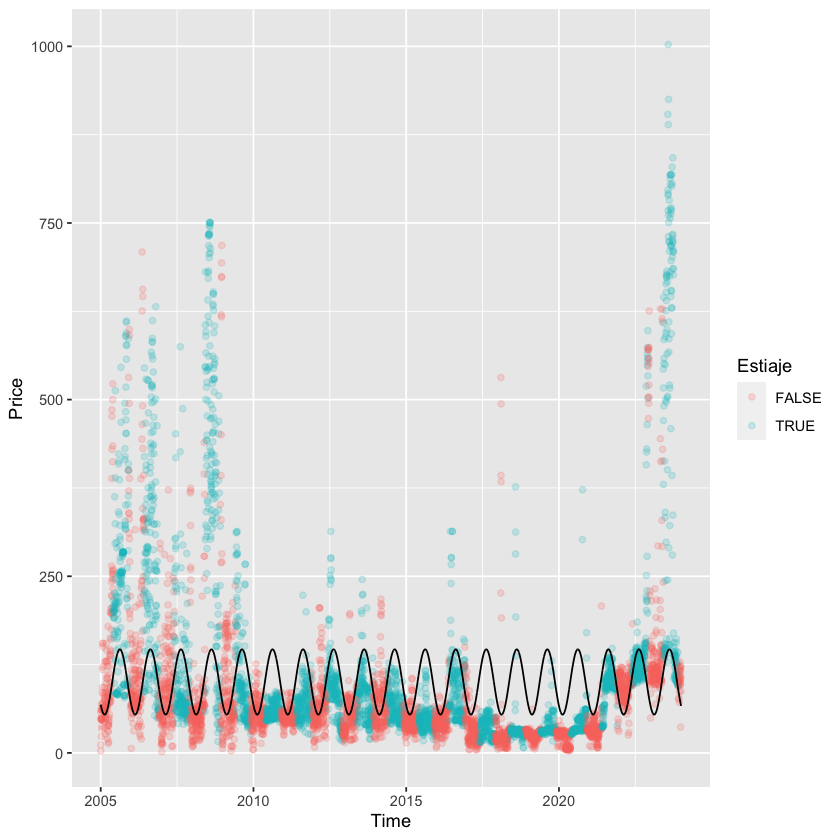

In [23]:
ds %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price))

Calibración tomado ventanas de datos / Periodo 2005 - 2009
===

Creamos una venta de datos para el periodo 2005 - 2009, porque visualmente se puede identificar un quiebre en el comportamiento del precio posterior a ese periodo.


Formula: Price ~ f_determ(t, my_alpha, my_gamma, my_Tao)

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
my_alpha  166.316      3.273   50.81   <2e-16 ***
my_gamma  -97.214      4.629  -21.00   <2e-16 ***
my_Tao   4330.743      2.766 1565.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 139.9 on 1823 degrees of freedom

Number of iterations to convergence: 5 
Achieved convergence tolerance: 5.615e-07


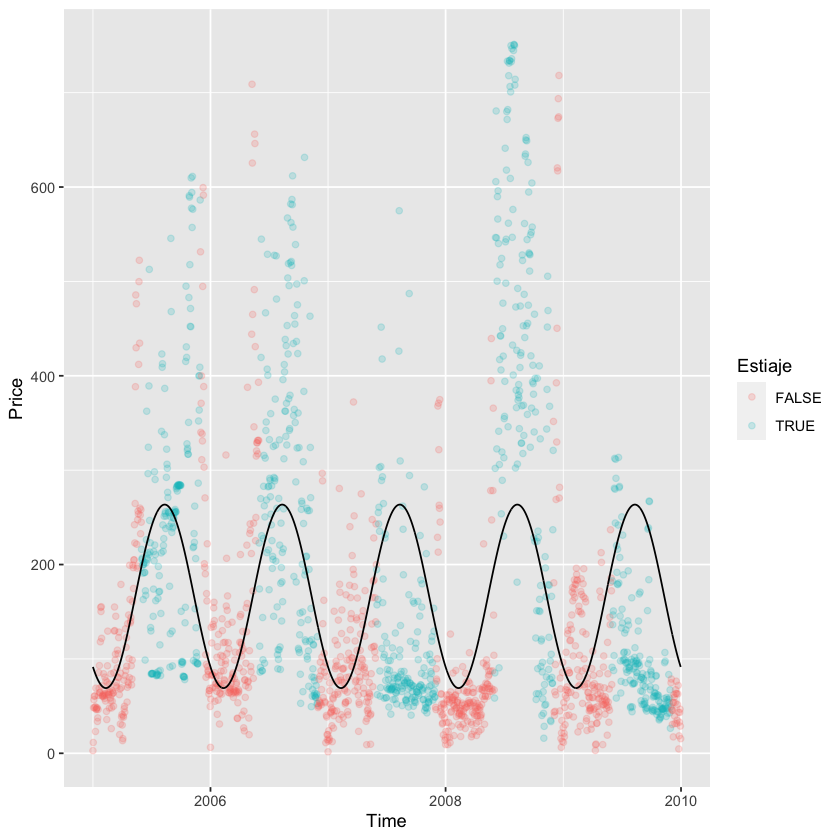

In [24]:
ds_fase_1 <- ds %>%
  filter(Year_dat <= 2009)

f_determ <- function(t,alpha,gamma,Tao) {
  (alpha + gamma*cos((t+Tao)*2*pi/365))
}

model1_1 <- nls(Price ~ f_determ(t,my_alpha,my_gamma,my_Tao),
                data=ds_fase_1,
                start = list(my_alpha=1, my_gamma=1, my_Tao=1)
)

summary(model1_1)

fit_Price_1 <- predict(model1_1)

ds_fase_1 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_1))

Calibración para el periodo 2010 - 2020
===


Formula: Price ~ f_determ(t, my_alpha, my_gamma, my_Tao)

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
my_alpha  53.1342     0.5607   94.77   <2e-16 ***
my_gamma -10.0019     0.7928  -12.62   <2e-16 ***
my_Tao   317.4361     4.6057   68.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.54 on 4015 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 2.993e-08


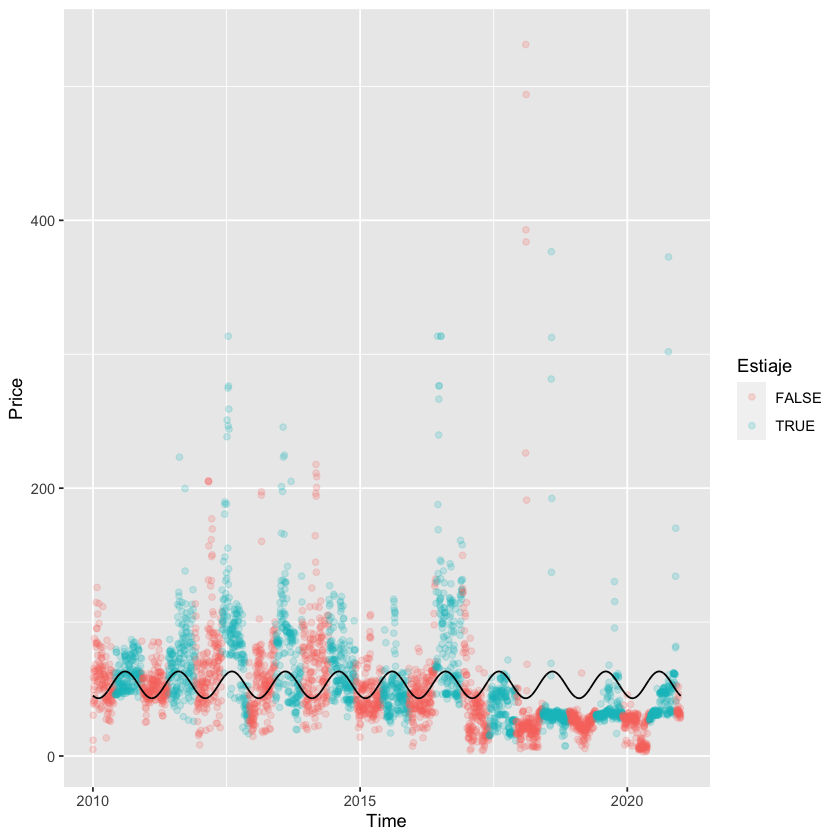

In [25]:
ds_fase_2 <- ds %>%
  filter(Year_dat >= 2010 & Year_dat <= 2020)

f_determ <- function(t,alpha,gamma,Tao) {
  (alpha + gamma*cos((t+Tao)*2*pi/365))
}

model1_2 <- nls(Price ~ f_determ(t,my_alpha,my_gamma,my_Tao),
                data=ds_fase_2,
                start = list(my_alpha=1, my_gamma=1, my_Tao=1)
)

summary(model1_2)

fit_Price_2 <- predict(model1_2)

ds_fase_2 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_2))


Calibración para el periodo 2021 - 2023
===


Formula: Price ~ f_determ(t, my_alpha, my_gamma, my_Tao)

Parameters:
         Estimate Std. Error t value Pr(>|t|)    
my_alpha  163.867      5.074    32.3   <2e-16 ***
my_gamma  -97.571      7.175   -13.6   <2e-16 ***
my_Tao   9785.982      4.272  2290.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 167.9 on 1092 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 5.405e-06


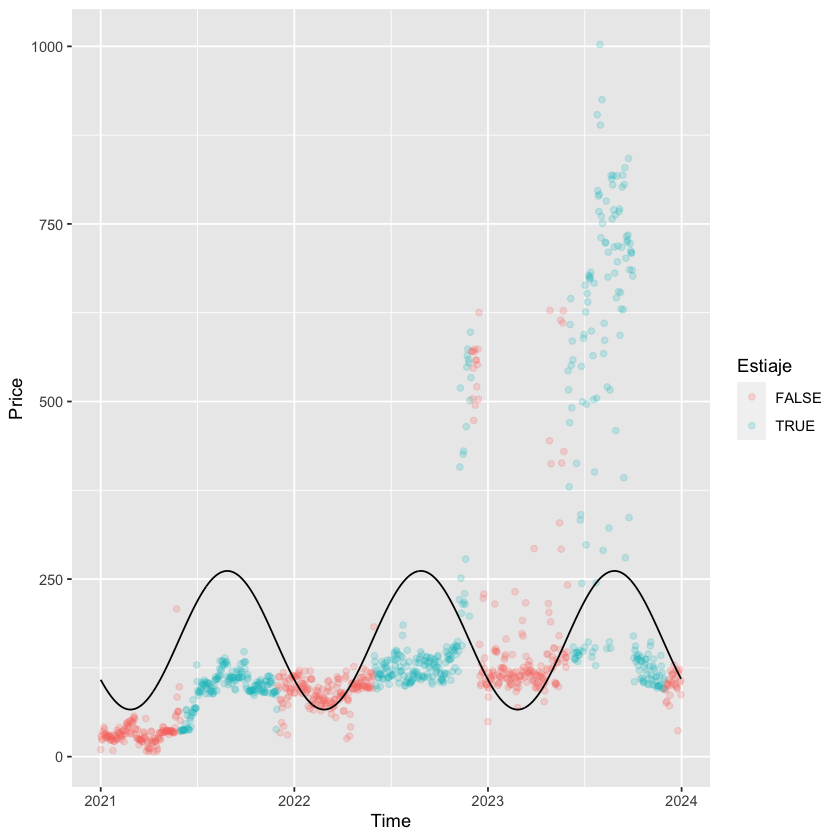

In [26]:
ds_fase_3 <- ds %>%
  filter(Year_dat > 2020)

f_determ <- function(t,alpha,gamma,Tao) {
  (alpha + gamma*cos((t+Tao)*2*pi/365))
}

model1_3 <- nls(Price ~ f_determ(t,my_alpha,my_gamma,my_Tao),
                data=ds_fase_3,
                start = list(my_alpha=1, my_gamma=1, my_Tao=1)
)

summary(model1_3)

fit_Price_3 <- predict(model1_3)

ds_fase_3 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_3))

Comparación visual de la calibración por ventanas de tiempo
===

Creamos la curva sinusoidal con los parámetros de calibración de la curva ajustada que corresponden al periodo completo (sin ventanas) de los datos de precios spot, pero construyendo esa curva sólo para el periodo de la fase_1 (2005 - 2009).

In [27]:
v_predict_1 <- f_determ(ds_fase_1$t,100.397,-46.172,2134.485) 

Ahora graficaremos esa curva sinusoidal junto con la curva ajustada de la ventana 2005 - 2009 (llamada de fase_1) 

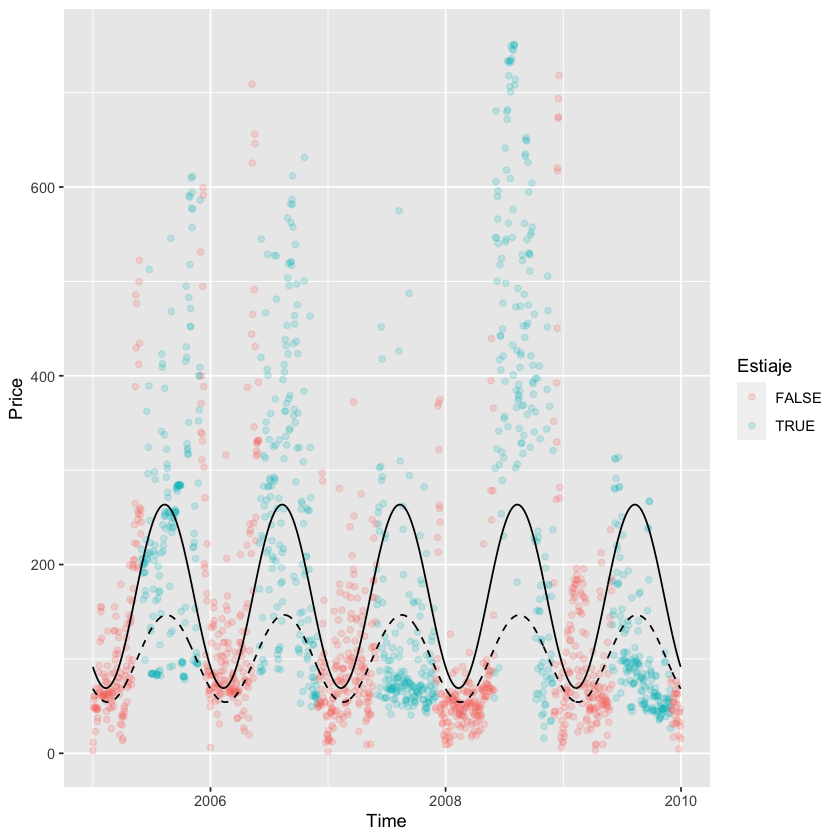

In [28]:
ds_fase_1 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_1)) +
  geom_line(aes(x=Time, y=v_predict_1), linetype="dashed")

Ahora creamos la curva sinusoidal con los parámetros de calibración de la curva ajustada que corresponden al periodo completo (sin ventanas) de los datos de precios spot, pero construyendo esa curva sólo para el periodo de la fase_2 (2010 - 2020).

In [30]:
v_predict_2 <- f_determ(ds_fase_2$t,100.397,-46.172,2134.485) 

Ahora graficaremos esa curva sinusoidal junto con la curva ajustada de la ventana 2010 - 2020 (llamada de fase_2)

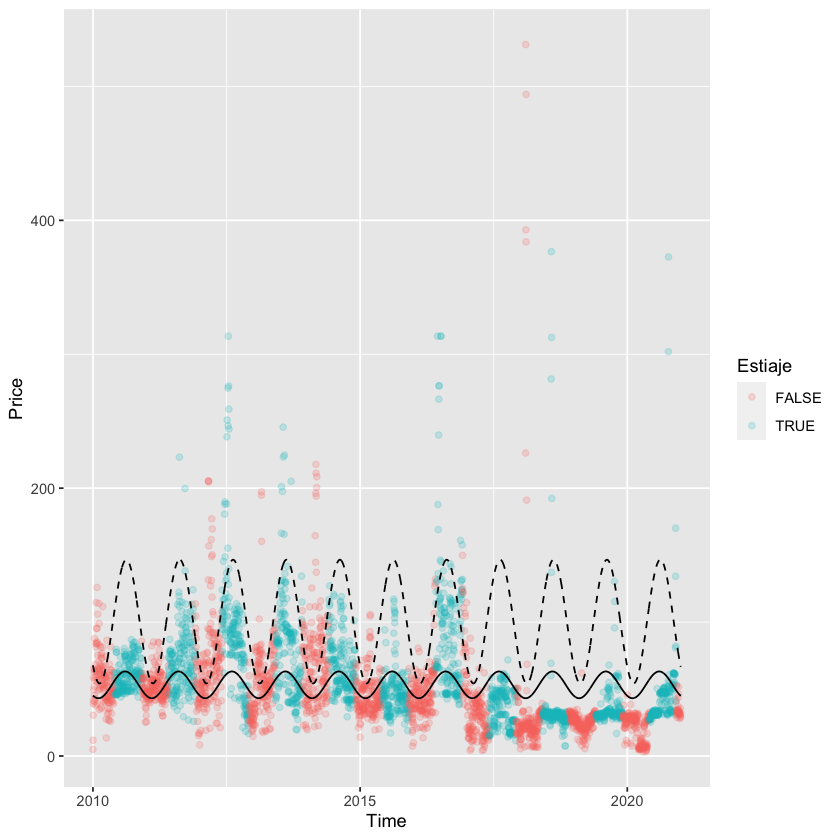

In [31]:
ds_fase_2 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_2)) +
  geom_line(aes(x=Time, y=v_predict_2), linetype="dashed")

Ahora lo mismo para la fase_3

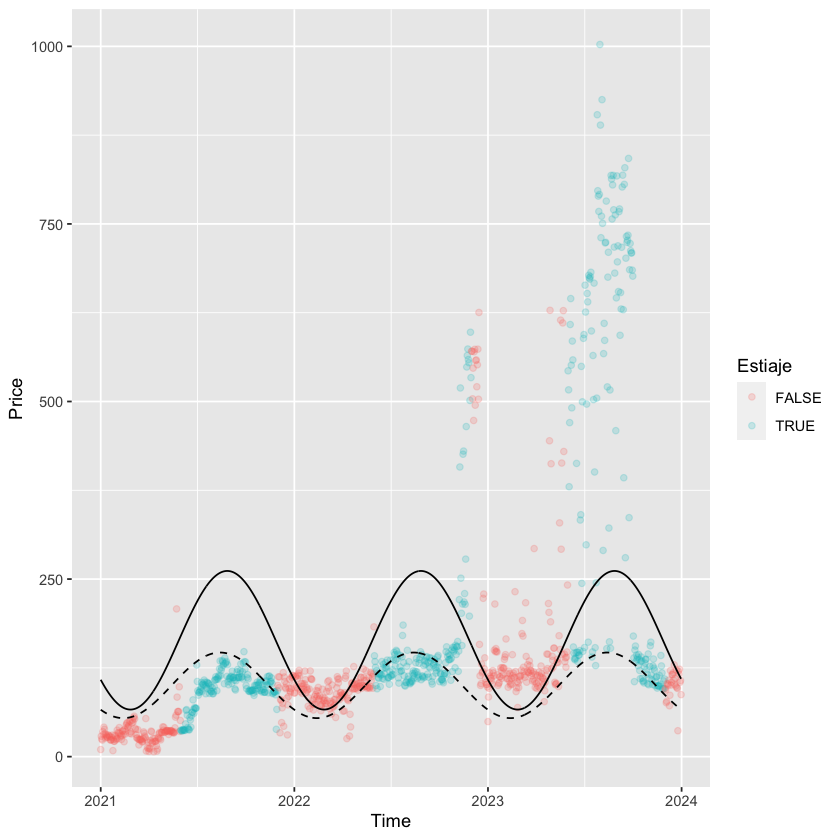

In [32]:
v_predict_3 <- f_determ(ds_fase_3$t,100.397,-46.172,2134.485) 

ds_fase_3 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_3)) +
  geom_line(aes(x=Time, y=v_predict_3), linetype="dashed")


Finalmente compararemos visualmente la calibración de la fase_1 con la calibración de la fase_3

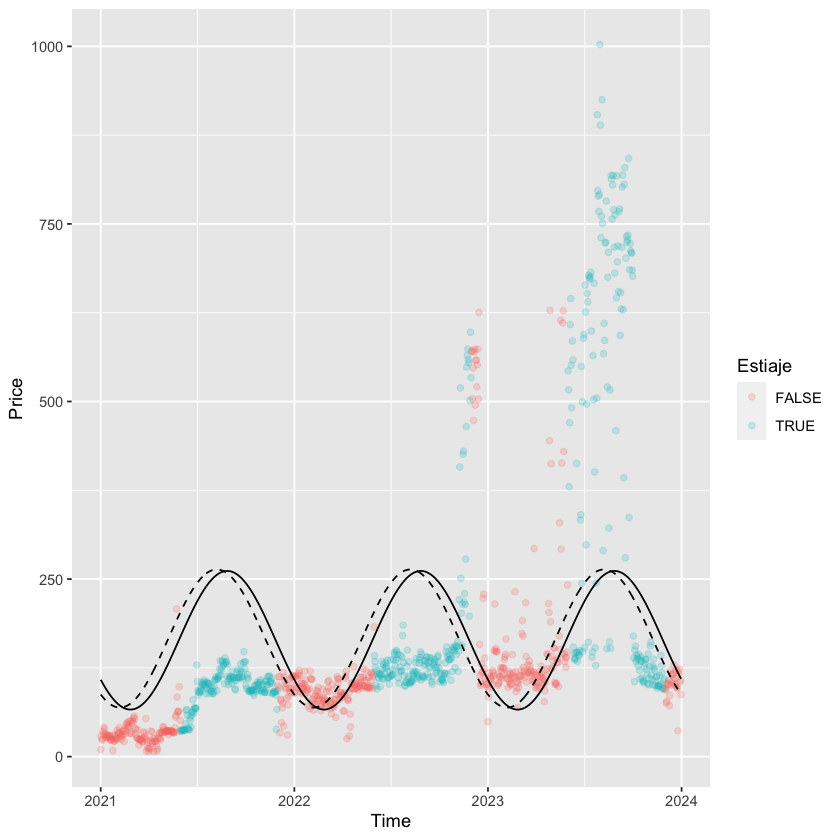

In [33]:
v_predict_3_1 <- f_determ(ds_fase_3$t,166.316,-97.214,4330.743) 

ds_fase_3 %>%
  ggplot() +
  geom_point(aes(x=Time, y=Price, color=Estiaje), alpha=0.2) +
  geom_line(aes(x=Time, y=fit_Price_3)) +
  geom_line(aes(x=Time, y=v_predict_3_1), linetype="dashed")
